In [1]:
from diffprivlib.mechanisms import Laplace as LaplaceMech
from diffprivlib.mechanisms import GaussianAnalytic as GaussianMech
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from dp_policy.titlei.utils import get_saipe, get_sppe
from dp_policy.titlei.bootstrap import collect_results
from dp_policy.titlei.mechanisms import Sampled

plt.style.use('seaborn-deep')

pd.options.mode.chained_assignment = None

num_bins = 15

%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'Sampled' from 'dp_policy.titlei.bootstrap' (/Users/steed/dp-acs/dp_policy/titlei/bootstrap.py)

In [ ]:
NUM_RUNS = 1000

saipe = get_saipe("../data/saipe19.xls")
sppe = get_sppe("../data/sppe18.xlsx")

## Run

In [127]:
# nonprivate
mech = Sampled(saipe)
results, results_nondp = collect_results(saipe, mech, sppe, num_runs=NUM_RUNS)
with open('../results/bootstrap/results_nondp.pkl', 'wb') as handle:
    pickle.dump(results_nondp, handle)
results.to_csv('../results/bootstrap/results_nondp.csv')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
delta = 1e-6
for epsilon in [
    0.01, 
    2.52,
    0.1,
#     1.0
]:
    # Laplace
    mech = Sampled(saipe, mechanism=LaplaceMech, epsilon=epsilon, delta=delta)
    results, results_laplace = collect_results(saipe, mech, sppe, num_runs=NUM_RUNS)
    print(len(results))
    with open('../results/bootstrap/results_laplace_eps={}.pkl'.format(epsilon), 'wb') as handle:
        pickle.dump(results_laplace, handle)
    results.to_csv('../results/bootstrap/results_laplace_eps={}.csv'.format(epsilon))

    # Gaussian
    mech = Sampled(saipe, mechanism=GaussianMech, epsilon=epsilon, delta=delta)
    results, results_gaussian = collect_results(saipe, mech, sppe, num_runs=NUM_RUNS)
    print(len(results))
    with open('../results/bootstrap/results_gaussian_eps={}.pkl'.format(epsilon), 'wb') as handle:
        pickle.dump(results_gaussian, handle)
    results.to_csv('../results/bootstrap/results_gaussian_eps={}.csv'.format(epsilon))

  0%|          | 0/1000 [00:00<?, ?it/s]

## Analyze

In [121]:
col_grant = "total" # choices: basic, targeted, concentration, total
epsilon = 0.1

In [122]:
with open("../results/bootstrap/results_nondp.pkl", 'rb') as handle:
    results_sampling = pickle.load(handle)
df_sampling = pd.read_csv("../results/bootstrap/results_nondp.csv")

path_laplace = "../results/bootstrap/results_laplace_eps={}.pkl".format(epsilon)
with open(path_laplace, 'rb') as handle:
    results_laplace = pickle.load(handle)
df_laplace = pd.read_csv("../results/bootstrap/results_laplace_eps={}.csv".format(epsilon))
print(len(df_laplace))

path_gaussian = "../results/bootstrap/results_gaussian_eps={}.pkl".format(epsilon)
with open(path_gaussian, 'rb') as handle:
    results_gaussian = pickle.load(handle)
df_gaussian = pd.read_csv("../results/bootstrap/results_gaussian_eps={}.csv".format(epsilon))

1318200


## Likelihood of being cheated

Want to know: how likely is it that a district is cheated, compared to the "true" prior?

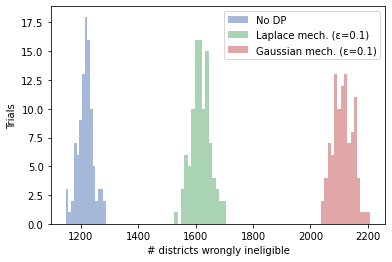

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


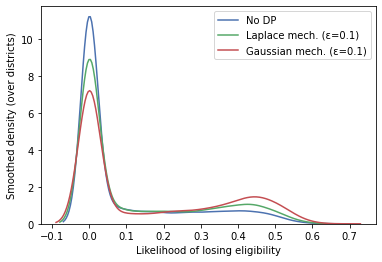

In [123]:
for treatment, df in {
    "No DP": df_sampling,
  "Laplace mech. (ε={})".format(epsilon): df_laplace,
  "Gaussian mech. (ε={})".format(epsilon): df_gaussian,
}.items():
    # "cheated" when ineligible but should have been eligible under the prior
    if col_grant == "total":
        df["lost_eligibility"] = \
            (df["est_eligible_basic"] & ~df["true_eligible_basic"]) |\
            (df["est_eligible_concentration"] & ~df["true_eligible_concentration"]) |\
            (df["est_eligible_targeted"] & ~df["true_eligible_targeted"])
    else:
        df["lost_eligibility"] = \
            ~df["est_eligible_{}".format(col_grant)] & df["true_eligible_{}".format(col_grant)]
    x = df.groupby('run')["lost_eligibility"].sum()
    plt.hist(x, bins=num_bins, label=treatment, alpha=0.5)
    #   sns.kdeplot(x, bw=0.4, label=treatment)

plt.xlabel("# districts wrongly ineligible")
plt.ylabel("Trials")
plt.legend(loc='upper right')
plt.show()


for treatment, df in {
    "No DP": df_sampling,
    "Laplace mech. (ε={})".format(epsilon): df_laplace,
    "Gaussian mech. (ε={})".format(epsilon): df_gaussian,
}.items():
    # "cheated" when ineligible but should have been eligible under the prior
    if col_grant == "total":
        df["lost_eligibility"] = \
            (df["est_eligible_basic"] & ~df["true_eligible_basic"]) |\
            (df["est_eligible_concentration"] & ~df["true_eligible_concentration"]) |\
            (df["est_eligible_targeted"] & ~df["true_eligible_targeted"])
    else:
        df["lost_eligibility"] = \
            ~df["est_eligible_{}".format(col_grant)] & df["true_eligible_{}".format(col_grant)]
    x = df.groupby(['State FIPS Code', 'District ID'])["lost_eligibility"].mean()
    #   plt.hist(x, bins=num_bins, label=treatment, alpha=0.5)
    sns.kdeplot(x, bw=0.15, label=treatment)

plt.xlabel("Likelihood of losing eligibility")
plt.ylabel("Smoothed density (over districts)")
plt.legend(loc='upper right')
plt.show()

1318200
1318200
1318200


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


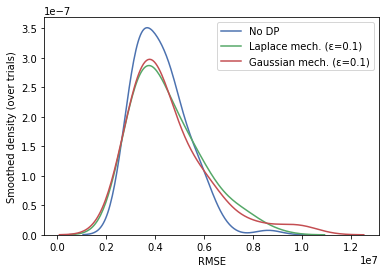

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


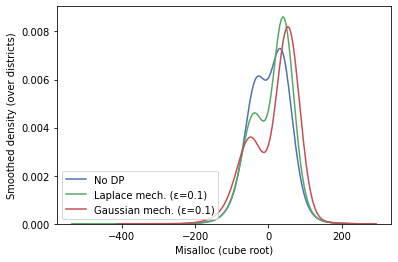

In [124]:
for treatment, df in {
    "No DP": df_sampling,
  "Laplace mech. (ε={})".format(epsilon): df_laplace,
  "Gaussian mech. (ε={})".format(epsilon): df_gaussian,
}.items():
  print(len(df))
  # "cheated" when ineligible but should have been eligible under the prior
  df["misalloc"] = df["diff_grant_{}".format('basic')] + \
    df["diff_grant_{}".format('targeted')] + \
    df["diff_grant_{}".format('concentration')]
  df["misalloc_sq"] = np.power(df["misalloc"], 2)
  x = np.sqrt(df.groupby('run')["misalloc_sq"].mean())
#   plt.hist(x, bins=num_bins, label=treatment, alpha=0.5)
  sns.kdeplot(x, bw=0.5, label=treatment)

plt.xlabel("RMSE")
plt.ylabel("Smoothed density (over trials)")
plt.legend(loc='upper right')
plt.show()


fig, ax = plt.subplots()
for treatment, df in {
    "No DP": df_sampling,
  "Laplace mech. (ε={})".format(epsilon): df_laplace,
  "Gaussian mech. (ε={})".format(epsilon): df_gaussian,
}.items():
  # "cheated" when ineligible but should have been eligible under the prior
  df["misalloc"] = df["diff_grant_{}".format('basic')] + \
    df["diff_grant_{}".format('targeted')] + \
    df["diff_grant_{}".format('concentration')]
  x = df.groupby(['State FIPS Code', 'District ID'])["misalloc"].mean()
#   plt.hist(np.sign(x)*np.power(np.abs(x), 1/3), bins=num_bins, label=treatment, alpha=0.7)
  sns.kdeplot(np.sign(x)*np.power(np.abs(x), 1/3), bw=0.5, label=treatment)

plt.xlabel("Misalloc (cube root)")
plt.ylabel("Smoothed density (over districts)")
plt.legend(loc='lower left')
plt.show()

<ipython-input-125-f477aa6a71cd>:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_laplace[mask].groupby(group)["est_grant_total"].mean().rename('dp'),
<ipython-input-125-f477aa6a71cd>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_laplace[mask].groupby(group)["est_grant_total"].quantile(alpha/2).rename('dp_lower'),
<ipython-input-125-f477aa6a71cd>:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_laplace[mask].groupby(group)["est_grant_total"].quantile(1-alpha/2).rename('dp_upper'),
<ipython-input-125-f477aa6a71cd>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_gaussian[mask].groupby(group)["est_grant_total"].mean().rename('gaus'),
<ipython-input-125-f477aa6a71cd>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_gaussian[mask].groupby(group)["est_grant_total"].quantile(alpha/2).rename('gaus_lower'),
<ipyth

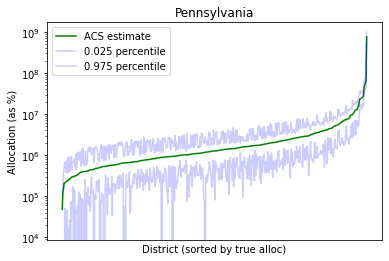

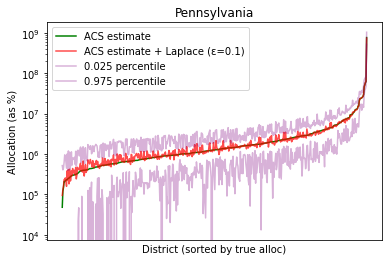

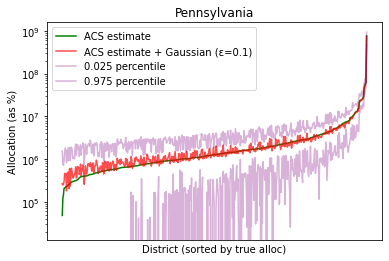

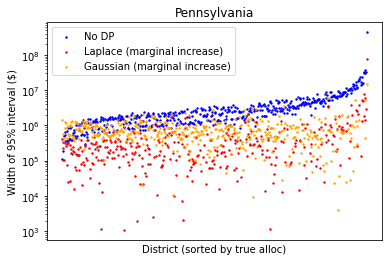

In [125]:
df = df_sampling
for pref in ["true", "est"]:
    df[f"{pref}_grant_total"] = df[f"{pref}_grant_basic"] + \
    df[f"{pref}_grant_targeted"] + \
    df[f"{pref}_grant_concentration"]

    df_laplace[f"{pref}_grant_total"] = df_laplace[f"{pref}_grant_basic"] + \
    df_laplace[f"{pref}_grant_targeted"] + \
    df_laplace[f"{pref}_grant_concentration"]

    df_gaussian[f"{pref}_grant_total"] = df_gaussian[f"{pref}_grant_basic"] + \
    df_gaussian[f"{pref}_grant_targeted"] + \
    df_gaussian[f"{pref}_grant_concentration"]

df = df.sort_values("true_grant_total")

alpha = 0.05
group = ['State FIPS Code', 'District ID']
mask = df["State FIPS Code"] == 42
bounds = pd.concat([
    df[mask].groupby(group)["true_grant_total"].mean().rename('true'),
    df[mask].groupby(group)["est_grant_total"].quantile(alpha/2).rename('bootstrap_lower'),
    df[mask].groupby(group)["est_grant_total"].quantile(1-alpha/2).rename('bootstrap_upper'),
    df_laplace[mask].groupby(group)["est_grant_total"].mean().rename('dp'),
    df_laplace[mask].groupby(group)["est_grant_total"].quantile(alpha/2).rename('dp_lower'),
    df_laplace[mask].groupby(group)["est_grant_total"].quantile(1-alpha/2).rename('dp_upper'),
    df_gaussian[mask].groupby(group)["est_grant_total"].mean().rename('gaus'),
    df_gaussian[mask].groupby(group)["est_grant_total"].quantile(alpha/2).rename('gaus_lower'),
    df_gaussian[mask].groupby(group)["est_grant_total"].quantile(1-alpha/2).rename('gaus_upper')
], axis=1).sort_values("true")
# sanity check
assert (bounds.true < bounds.bootstrap_lower).sum() == 0
assert (bounds.true > bounds.bootstrap_upper).sum() == 0

x = range(len(bounds))
ax = plt.gca()
plt.plot(x, bounds.true, color='green', label='ACS estimate')
plt.plot(x, bounds.bootstrap_lower, label=f"{alpha/2} percentile", color='b', alpha=0.2)
plt.plot(x, bounds.bootstrap_upper, label=f"{1-alpha/2} percentile", color='b', alpha=0.2)
# ax.fill_between(
#     x, 
#     bounds.bootstrap_lower, bounds.bootstrap_upper, 
#     color='b', alpha=0.1, label="95% CI, relative error"
# )
ax.axes.xaxis.set_ticks([])
ax.set_yscale('log')
plt.title("Pennsylvania")
plt.legend()
plt.xlabel("District (sorted by true alloc)")
plt.ylabel("Allocation (as %)")
plt.show()

ax = plt.gca()
plt.plot(x, bounds.true, color='green', label='ACS estimate')
plt.plot(x, bounds.dp, color='red', label='ACS estimate + Laplace (ε={})'.format(epsilon), alpha=0.7)
plt.plot(x, bounds.dp_lower, label=f"{alpha/2} percentile", color='purple', alpha=0.3)
plt.plot(x, bounds.dp_upper, label=f"{1-alpha/2} percentile", color='purple', alpha=0.3)
# ax.fill_between(
#     x, 
#     bounds.dp_lower, bounds.dp_upper, 
#     color='orange', alpha=0.1, label="95% CI, relative + DP error"
# )

ax.axes.xaxis.set_ticks([])
ax.set_yscale('log')
plt.title("Pennsylvania")
plt.legend()
plt.xlabel("District (sorted by true alloc)")
plt.ylabel("Allocation (as %)")
plt.show()

ax = plt.gca()
plt.plot(x, bounds.true, color='green', label='ACS estimate')
plt.plot(x, bounds.gaus, color='red', label='ACS estimate + Gaussian (ε={})'.format(epsilon), alpha=0.7)
plt.plot(x, bounds.gaus_lower, label=f"{alpha/2} percentile", color='purple', alpha=0.3)
plt.plot(x, bounds.gaus_upper, label=f"{1-alpha/2} percentile", color='purple', alpha=0.3)
# ax.fill_between(
#     x, 
#     bounds.dp_lower, bounds.dp_upper, 
#     color='orange', alpha=0.1, label="95% CI, relative + DP error"
# )

ax.axes.xaxis.set_ticks([])
ax.set_yscale('log')
plt.title("Pennsylvania")
plt.legend()
plt.xlabel("District (sorted by true alloc)")
plt.ylabel("Allocation (as %)")
plt.show()


ax = plt.gca()
baseline = bounds.bootstrap_upper - bounds.bootstrap_lower
s = 2.0
plt.scatter(x, baseline, color='blue', label='No DP', s=s)
plt.scatter(x, bounds.dp_upper - bounds.dp_lower - baseline, label=f"Laplace (marginal increase)", s=s, color='red')
plt.scatter(x, bounds.gaus_upper - bounds.gaus_lower - baseline, label=f"Gaussian (marginal increase)",  s=s, color='orange')
# ax.fill_between(
#     x,
#     bounds.dp_lower, bounds.dp_upper, 
#     color='orange', alpha=0.1, label="95% CI, relative + DP error"
# )

ax.axes.xaxis.set_ticks([])
ax.set_yscale('log')
plt.title("Pennsylvania")
plt.legend()
plt.xlabel("District (sorted by true alloc)")
plt.ylabel(f"Width of {round((1-alpha)*100)}% interval ($)")
plt.show()

# Terrance plots

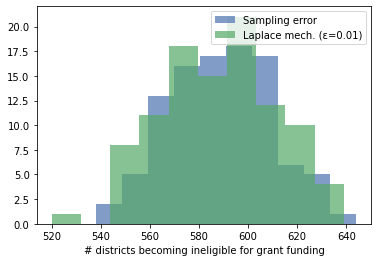

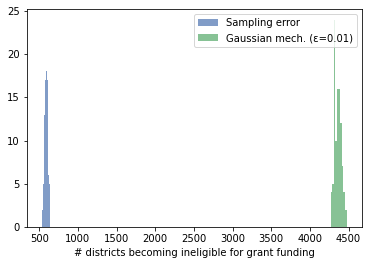

In [14]:
# Number ineligible
quantile = 'sum'
df_sampling = results_sampling[quantile]
df_laplace = results_laplace[quantile]
df_gaussian = results_gaussian[quantile]

x = df_sampling["diff_eligible_{}".format(col_grant)].values
y = df_laplace["diff_eligible_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Laplace mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("# districts becoming ineligible for grant funding")
plt.legend(loc='upper right')
plt.show()

y = df_gaussian["diff_eligible_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Gaussian mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("# districts becoming ineligible for grant funding")
plt.legend(loc='upper right')
plt.show()

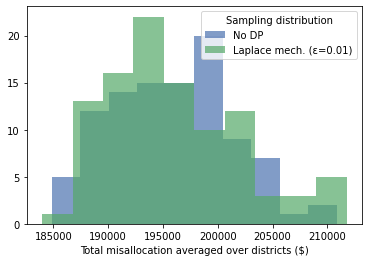

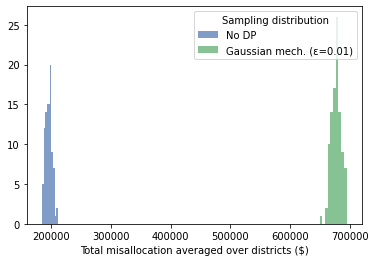

In [38]:
# Average misallocation

quantile = 'mean'
df_sampling = results_sampling[quantile]
df_laplace = results_laplace[quantile]
df_gaussian = results_gaussian[quantile]

x = df_sampling["diff_grant_{}".format(col_grant)].values

y = df_laplace["diff_grant_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="No DP", alpha=0.7)
plt.hist(y, bins=num_bins, label="Laplace mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right', title="Sampling distribution")
plt.show()

y = df_gaussian["diff_grant_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="No DP", alpha=0.7)
plt.hist(y, bins=num_bins, label="Gaussian mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right', title="Sampling distribution")
plt.show()

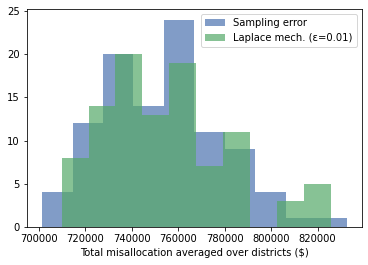

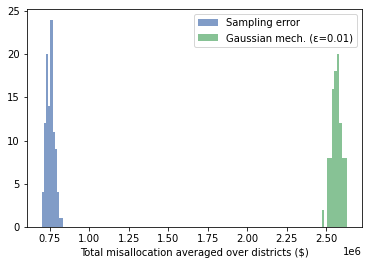

In [39]:
# Average misallocation (sum of all three grant types)
quantile = 'mean'
df_sampling = results_sampling[quantile]
df_laplace = results_laplace[quantile]
df_gaussian = results_gaussian[quantile]

x = df_sampling["diff_grant_{}".format('basic')].values + \
    df_sampling["diff_grant_{}".format('targeted')].values + \
    df_sampling["diff_grant_{}".format('concentration')].values

y = df_laplace["diff_grant_{}".format('basic')].values + \
    df_laplace["diff_grant_{}".format('targeted')].values + \
    df_laplace["diff_grant_{}".format('concentration')].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Laplace mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right')
plt.show()

y = df_gaussian["diff_grant_{}".format('basic')].values + \
    df_gaussian["diff_grant_{}".format('targeted')].values + \
    df_gaussian["diff_grant_{}".format('concentration')].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Gaussian mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right')
plt.show()